<a href="https://colab.research.google.com/gist/adoskk/c3d96e4c7ae15a48c2a9ea8bc835ca39/lstm_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all necessary modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from datetime import datetime
import re
torch.manual_seed(1)

# manual parameters

In [2]:
# set manual parameters
sequence_length = 20 # use previous 19 days to predict the 20th day
test_ratio = 0.2 # train on the first 80% data and test on the rest 20%

# import Nasdaq index data, visualize

          Date          Open  ...     Adj Close      Volume
0   2019-12-02   8672.839844  ...   8567.990234  2225940000
1   2019-12-03   8460.719727  ...   8520.639648  2308600000
2   2019-12-04   8557.450195  ...   8566.669922  2150680000
3   2019-12-05   8587.929688  ...   8570.700195  2123380000
4   2019-12-06   8634.250000  ...   8656.530273  2053530000
..         ...           ...  ...           ...         ...
248 2020-11-24  11939.330078  ...  12036.790039  6277790000
249 2020-11-25  12053.889648  ...  12094.400391  4425030000
250 2020-11-27  12159.179688  ...  12205.849609  3401890000
251 2020-11-30  12224.250000  ...  12198.740234  7693430000
252 2020-12-01  12313.400391  ...  12355.106445  1844010125

[253 rows x 7 columns]


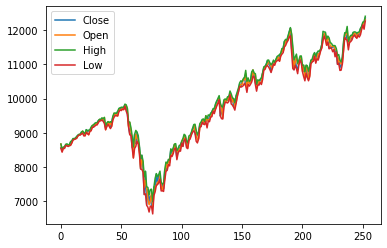

In [10]:
df = pd.read_excel(r'IXIC.xlsx')
print(df)


df['Close'].interpolate().plot()
df['Open'].interpolate().plot()
df['High'].interpolate().plot()
df['Low'].interpolate().plot()
plt.legend(['Close', 'Open', 'High', 'Low'])
# we only predict on Close data in the following

# Create data loader
### Note: normalize the stock value to avoid node saturation

In [11]:
def load_data(stock_raw, sequence_length):
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(stock_raw) - sequence_length): 
        data.append(stock_raw[index: index + sequence_length])
    
    data = np.array(data);
    test_set_size = int(np.round(test_ratio*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = np.reshape(data[:train_set_size,:-1], (train_set_size, sequence_length-1, 1))/10000
    y_train = np.reshape(data[:train_set_size, -1], (train_set_size, 1))/10000
    
    x_test = np.reshape(data[train_set_size:,:-1], (test_set_size, sequence_length-1, 1))/10000
    y_test = np.reshape(data[train_set_size:,-1], (test_set_size, 1))/10000
    
    return [x_train, y_train, x_test, y_test]


x_train, y_train, x_test, y_test = load_data(df['Close'], sequence_length)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (186, 19, 1)
y_train.shape =  (186, 1)
x_test.shape =  (47, 19, 1)
y_test.shape =  (47, 1)


In [12]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [13]:
n_steps = sequence_length-1
batch_size = 20


train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)

train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=1, 
                                          shuffle=False)

# Build the 2-layer stateless LSTM model

In [14]:
# Build model
#####################
input_dim = 1
hidden_dim = 128
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # use stateless LSTM
        self.hidden_cell = (torch.zeros(1,1,self.hidden_dim),
                            torch.zeros(1,1,self.hidden_dim))
        
        # Building your LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        out = self.fc(out[:, -1, :]) 
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.L1Loss()

optimiser = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train

In [15]:
# Train model
#####################
num_epochs = 2000

hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =sequence_length-1  

model.train()
for t in range(num_epochs):
        
    # Forward pass
    for x_epoch, y_epoch in train_loader:

      model.hidden_cell = (torch.zeros(1, 1, model.hidden_dim),
                        torch.zeros(1, 1, model.hidden_dim))
      
      y_train_pred = model(x_epoch)

      loss = loss_fn(y_train_pred, y_epoch)       
      hist[t] += loss.item()

      # Zero out gradient, else they will accumulate between epochs
      optimiser.zero_grad()

      # Backward pass
      loss.backward()

      # Update parameters
      optimiser.step()
    
    if t % 200 == 0 and t !=0:
          print("Epoch ", t, "MSE: ", hist[t])    

Epoch  200 MSE:  0.8419070802628994
Epoch  400 MSE:  0.23240907303988934
Epoch  600 MSE:  0.2164689600467682
Epoch  800 MSE:  0.23969682026654482
Epoch  1000 MSE:  0.22315163724124432
Epoch  1200 MSE:  0.21679497696459293
Epoch  1400 MSE:  0.20356636494398117
Epoch  1600 MSE:  0.20067269075661898
Epoch  1800 MSE:  0.2061743075028062


# Visualize test result

Test Score: 0.02 RMSE


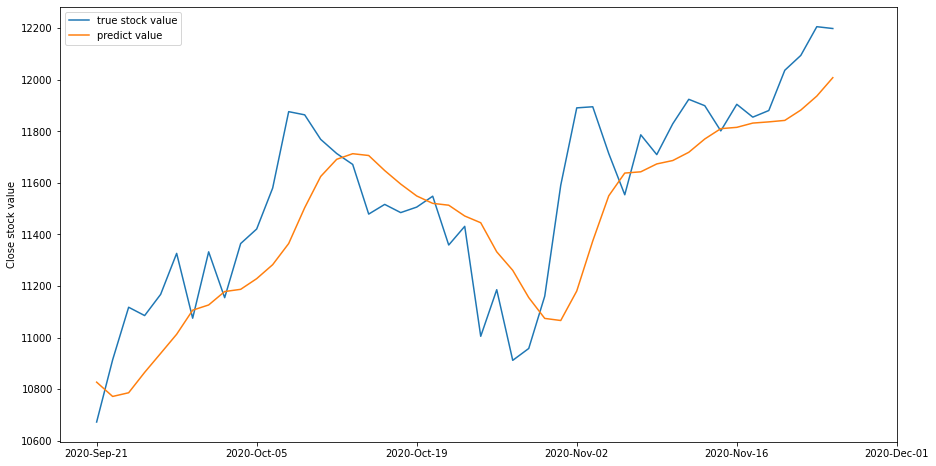

In [19]:
# make predictions
test_set_size = int(np.round(test_ratio*df['Close'].shape[0]));
train_set_size = df['Close'].shape[0] - (test_set_size);
time_stamp = pd.to_datetime(df['Date'])[train_set_size:]
timestamp_str = time_stamp.apply(lambda x: x.strftime('%Y-%b-%d'))

test_score = 0.0
y_test_pred = []
model.eval()
for x_testtime, y_testtime in test_loader:
  pred = model(x_testtime)
  pred = pred.detach().numpy()
  test_score += (pred[0, 0] - y_testtime)**2
  y_test_pred.append(pred[0, 0])

# print(y_test_pred)
print('Test Score: %.2f RMSE' % (math.sqrt(test_score/test_set_size)))

plt.figure(figsize=(15,8))
a = [10000*r for r in np.ndarray.tolist(np.reshape(y_test[:, 0].detach().numpy(), [len(y_test_pred)]))]
plt.plot(a)
plt.plot([10000*r for r in y_test_pred])
plt.legend(['true stock value', 'predict value'])
xtick = range(0, test_set_size, 10)
xticklabel = timestamp_str[0:test_set_size:10]
plt.xticks(xtick, xticklabel)
plt.ylabel('Close stock value')
plt.show()